## A1: Data Curation Assignment

The goal of this assignment is to construct, analyze, and publish a dataset of monthly traffic on English Wikipedia from January 1 2008 through September 30 2021. 

We will combine data about Wikipedia page traffic from two different Wikimedia REST API endpoints into a single dataset, perform some simple data processing steps on the data, and then analyze that data.

In [1]:
import json
import requests
import os
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter

### Step 1: Data Acquisition

We will collect data from two different API endpoints, the Legacy Pagecounts API and the Pageviews API.

- The Legacy Pagecounts API provides access to desktop and mobile traffic data from December 2007 through July 2016. ([documentation](https://wikitech.wikimedia.org/wiki/Analytics/AQS/Legacy_Pagecounts), [endpoint](https://wikimedia.org/api/rest_v1/#!/Pagecounts_data_(legacy)/get_metrics_legacy_pagecounts_aggregate_project_access_site_granularity_start_end))

- The Pageviews API provides access to desktop, mobile web, and mobile app traffic data from July 2015 through last month. ([documentation](https://wikitech.wikimedia.org/wiki/Analytics/AQS/Pageviews), [endpoint](https://wikimedia.org/api/rest_v1/#!/Pageviews_data/get_metrics_pageviews_aggregate_project_access_agent_granularity_start_end))

For each API, we will collect data for all months where data is available and then save the raw results into 5 separate JSON source data files (one file per API query type).

In [2]:
endpoint_legacy = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'
endpoint_pageviews = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'

headers = {
    'User-Agent': 'https://github.com/StaceyWheeler',
    'From': 'swheele@uw.edu'
}

Here we define 2 functions to make the API call and save the result. The JSON-formatted source data files will contain the complete and unedited output of your API queries. The naming convention for the source data files is: `apiname_accesstype_firstmonth-lastmonth.json`.

In [3]:
def api_call(endpoint,parameters):
    """
    Returns a json object from the API call for the given endpoint.
    """
    call = requests.get(endpoint.format(**parameters), headers=headers)
    response = call.json()
    
    return response

In [4]:
def get_data():
    """
    When this function is called, a dictionary is created for the parameters before an API call is made. Then the JSON is saved with the correct file name.
    """
    for access in ['desktop-site', 'mobile-site']:
        
        parameters_legacy = {
                                'project': 'en.wikipedia.org',
                                'access-site': access,
                                'granularity': 'monthly',
                                'start': 2007120100, # December 2007
                                'end': 2016080100 # Ending July 2016
                            }
        
        monthly_legacy = api_call(endpoint_legacy, parameters_legacy)
        
        legacy_file_name = f'pagecounts_{access}_{2007120100}-{2016080100}.json'
        file_path = os.path.join('../data/raw', legacy_file_name) 
        with open(file_path, 'w') as f:
            json.dump(monthly_legacy, f)
            
    for access in ['desktop', 'mobile-app', 'mobile-web']:
            
        parameters_pageviews = {
                                    'project': 'en.wikipedia.org',
                                    'access': access,
                                    'agent': 'user', # Only available in pageview API. Eliminates crawlers.
                                    'granularity': 'monthly',
                                    'start': 2015070100, # July 2015
                                    'end': 2021100100 # Ending September 2021
                                }
            
        monthly_pageviews = api_call(endpoint_pageviews, parameters_pageviews)
        
        pageviews_file_name = f'pageviews_{access}_{2015070100}-{2021100100}.json'
        file_path = os.path.join('../data/raw', pageviews_file_name) 
        with open(file_path, 'w') as f:
            json.dump(monthly_pageviews, f)

In [5]:
get_data()

### Step 2: Data Processing

Now that we've saved the data, we want to complete the preprocessing. We will read it in as a pandas dataframe, complete the preprocessing, and saves as a csv. Ideally we can read in the csv and plot it without any futher preprocessing.

In [6]:
raw_file_names = [x for x in os.listdir('../data/raw') if '.json' in x]

df_list = []

# Iterating through the file names in ../data/raw, we read in the data from the JSON objects as pd df.
for raw_file_name in raw_file_names:
    with open(os.path.join('../data/raw', raw_file_name), 'r') as f:
      data = json.load(f)

    df = pd.json_normalize(data,['items'])
    df['Source'] = '_'.join(raw_file_name.split('_')[:2]) # Source column will be used to pivot in next step
    
    df_list.append(df)

# Concat the data into a single df
df = pd.concat(df_list)

In [7]:
df

,project,access-site,granularity,timestamp,count,Source,access,agent,views
0,en.wikipedia,mobile-site,monthly,2014100100,3.091547e+09,pagecounts_mobile-site,NaN,NaN,NaN
1,en.wikipedia,mobile-site,monthly,2014110100,3.027490e+09,pagecounts_mobile-site,NaN,NaN,NaN
2,en.wikipedia,mobile-site,monthly,2014120100,3.278950e+09,pagecounts_mobile-site,NaN,NaN,NaN
3,en.wikipedia,mobile-site,monthly,2015010100,3.485302e+09,pagecounts_mobile-site,NaN,NaN,NaN
4,en.wikipedia,mobile-site,monthly,2015020100,3.091534e+09,pagecounts_mobile-site,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
70,en.wikipedia,NaN,monthly,2021050100,NaN,pageviews_mobile-app,mobile-app,user,166485079.0
71,en.wikipedia,NaN,monthly,2021060100,NaN,pageviews_mobile-app,mobile-app,user,150704624.0
72,en.wikipedia,NaN,monthly,2021070100,NaN,pageviews_mobile-app,mobile-app,user,161461155.0
73,en.wikipedia,NaN,monthly,2021080100,NaN,pageviews_mobile-app,mobile-app,user,161381193.0


Here we fill in views with all the values in count so we can drop the count column. We then drop all the unneeded columns. Finally we pivot the table using Source as the new columns. Notice that not every column contains a value for every month.

In [8]:
df['views'] = df['views'].combine_first(df['count'])
df.drop(columns=['project', 'granularity', 'count', 'access-site', 'access', 'agent'], inplace=True)
df = pd.pivot_table(df, values='views', columns='Source', index=['timestamp']).reset_index()

df

Source,timestamp,pagecounts_desktop-site,pagecounts_mobile-site,pageviews_desktop,pageviews_mobile-app,pageviews_mobile-web
0,2007120100,2.998332e+09,NaN,NaN,NaN,NaN
1,2008010100,4.930903e+09,NaN,NaN,NaN,NaN
2,2008020100,4.818394e+09,NaN,NaN,NaN,NaN
3,2008030100,4.955406e+09,NaN,NaN,NaN,NaN
4,2008040100,5.159162e+09,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
161,2021050100,NaN,NaN,2.824416e+09,166485079.0,4.810094e+09
162,2021060100,NaN,NaN,2.505971e+09,150704624.0,4.433806e+09
163,2021070100,NaN,NaN,2.765584e+09,161461155.0,4.617448e+09
164,2021080100,NaN,NaN,2.763414e+09,161381193.0,4.570813e+09


At this step we combine all data into a dataframe with 8 columns (year, month, and view count for all six access methods). We will fill the NaN values with 0 so we can take the sums. Finally we rename the columns and export the df to csv. 

In [9]:
# For all data, separate the value of timestamp into four-digit year (YYYY) and two-digit month (MM) and discard values for day and hour (DDHH).
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y%m%d%H')
df['year'] = df['timestamp'].dt.year
df['month'] = df['timestamp'].dt.month

# Fill NA values with 0 for all access methods.
df.fillna({'pagecounts_desktop-site':0, 
           'pagecounts_mobile-site':0,
           'pageviews_desktop':0,
           'pageviews_mobile-app':0,
           'pageviews_mobile-web':0}, inplace=True)

# For data collected from the Pageviews API, combine the monthly values for mobile-app and mobile-web to create a total mobile traffic count for each month.
df['pageview_mobile_views'] = df['pageviews_mobile-app'].fillna(0) + df['pageviews_mobile-web'].fillna(0)

# Find sum of pageviews and pagecounts.
df['pageview_all_views'] = df['pageview_mobile_views'].fillna(0) + df['pageviews_desktop'].fillna(0)
df['pagecount_all_views'] = df['pagecounts_desktop-site'].fillna(0) + df['pagecounts_mobile-site'].fillna(0)

df.rename(columns={'pagecounts_desktop-site': 'pagecount_desktop_views', 
                   'pagecounts_mobile-site': 'pagecount_mobile_views',
                   'pageviews_desktop': 'pageview_desktop_views'}, inplace=True)
df = df[['year', 
         'month', 
         'pagecount_all_views', 
         'pagecount_desktop_views', 
         'pagecount_mobile_views', 
         'pageview_all_views', 
         'pageview_desktop_views', 
         'pageview_mobile_views']]

In [10]:
df

Source,year,month,pagecount_all_views,pagecount_desktop_views,pagecount_mobile_views,pageview_all_views,pageview_desktop_views,pageview_mobile_views
0,2007,12,2.998332e+09,2.998332e+09,0.0,0.000000e+00,0.000000e+00,0.000000e+00
1,2008,1,4.930903e+09,4.930903e+09,0.0,0.000000e+00,0.000000e+00,0.000000e+00
2,2008,2,4.818394e+09,4.818394e+09,0.0,0.000000e+00,0.000000e+00,0.000000e+00
3,2008,3,4.955406e+09,4.955406e+09,0.0,0.000000e+00,0.000000e+00,0.000000e+00
4,2008,4,5.159162e+09,5.159162e+09,0.0,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...
161,2021,5,0.000000e+00,0.000000e+00,0.0,7.800996e+09,2.824416e+09,4.976580e+09
162,2021,6,0.000000e+00,0.000000e+00,0.0,7.090482e+09,2.505971e+09,4.584510e+09
163,2021,7,0.000000e+00,0.000000e+00,0.0,7.544494e+09,2.765584e+09,4.778909e+09
164,2021,8,0.000000e+00,0.000000e+00,0.0,7.495608e+09,2.763414e+09,4.732194e+09


In [11]:
processed_file_path = os.path.join('../data/processed', 'en-wikipedia_traffic_200712-202109.csv')
df.to_csv(processed_file_path, index=False)

### Step 3: Analysis and Visualization

We will read in the csv created in the previous step in order to visualize the dataset as a time series graph. Our visualization will track three traffic metrics: mobile traffic, desktop traffic, and all traffic (mobile + desktop). The x-values for our plot will be each month from January 2008 through September 2021.

In [12]:
df = pd.read_csv(processed_file_path)
df.replace(0, np.nan, inplace=True) # We do this so the zeros do not show up in the plot.

dates_df = df['month'].map(str)+ '-' +df['year'].map(str)
x=[datetime.datetime.strptime(d,'%m-%Y').date() for d in dates_df]

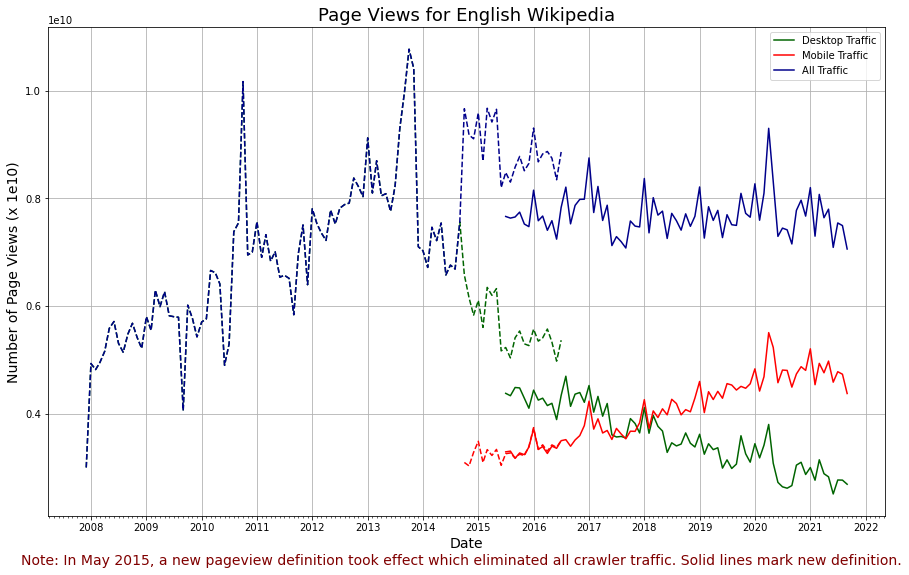

In [13]:
plt.figure(figsize=(15,9))
ax = plt.gca()

# Create lines and choose characteristics
plt.plot(x, 'pagecount_desktop_views', color='darkgreen', linestyle='dashed', data=df, label='')
plt.plot(x, 'pageview_desktop_views', color='darkgreen', linestyle='solid', data=df, label='Desktop Traffic')

plt.plot(x, 'pagecount_mobile_views', color='red', linestyle='dashed', data=df, label='')
plt.plot(x, 'pageview_mobile_views', color='red', linestyle='solid', data=df, label='Mobile Traffic')

plt.plot(x, 'pagecount_all_views', color='darkblue', linestyle='dashed', data=df, label='')
plt.plot(x, 'pageview_all_views', color='darkblue', linestyle='solid', data=df, label='All Traffic')

# Add title and axis names
plt.title('Page Views for English Wikipedia', fontsize=18)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Number of Page Views (x 1e10)', fontsize=14)

# format the x-ticks
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')

ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)

plt.legend()
plt.grid()

plt.figtext(0.1, 0.05, 
            'Note: In May 2015, a new pageview definition took effect which eliminated all crawler traffic. Solid lines mark new definition.', 
            horizontalalignment='left', 
            fontsize=14,
            color='maroon'
           )

plt.savefig(os.path.join('../data/visualization', 'en-wikipedia_traffic_200712-202109.png'))